<a href="https://colab.research.google.com/github/Ashik9576/Taxi-Time-Prediction/blob/main/Ashik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
# Importing the libraries
!pip install pycountry
!pip install haversine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pycountry as pc
import matplotlib.ticker as mtick
import plotly.express as px

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

     |████████████████████████████████| 10.1 MB 5.0 MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=e8a8ab53f4d318a3104cffc05f587137d03d7ee502a97f5978265de8deacaaba
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# creating directory path
nyc = pd.read_csv('/content/drive/MyDrive/NYC/NYC Taxi Data.csv')

In [ ]:
# visualizing 5 row of nyc dataset
nyc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
#checking types of values in store_and_fwd_flag
nyc.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [ ]:
# checking how many hour of value
nyc.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [27]:
# types of vendor_id
nyc.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [ ]:
# summery of dataframe
nyc.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
#no. of row and column
nyc.shape

(1458644, 11)

In [ ]:
#check null values in Data frame
nyc.isnull().sum()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

# **There are 1458644 rows and 11 columns**

In [ ]:
# creating a copy
nycc=nyc.copy()

In [ ]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
dmylp=[]                                               # storing date from pickup_datetime
hmslp=[]                                               # storing month from pickup_datetime
a=nycc['pickup_datetime']
for i in a:
  dmy=i.split()[0]
  hms=i.split()[1]
  dmylp.append(dmy)
  hmslp.append(hms)


dmyld=[]                                               # storing date from dropoff_datetime
hmsld=[]                                               # storing month from dropoff_datetime
b=nycc['dropoff_datetime']
for i in b:
  dmy=i.split()[0]
  hms=i.split()[1]
  dmyld.append(dmy)
  hmsld.append(hms)

In [ ]:
yearp=[]                                  # pickup_datetime year
monthp=[]                                 #pickup_datetime month
dayp=[]                                   #pickup_datetime day
for i in dmylp:
  w=datetime.strptime(i,"%Y-%m-%d")
  yearp.append(w.year)
  monthp.append(w.month)
  dayp.append(w.day)


yeard=[]                                  # dropoff_datetime year
monthd=[]                                 #dropoff_datetime month
dayd=[]                                   #dropoff_datetime day
for i in dmyld:
  w=datetime.strptime(i,"%Y-%m-%d")
  yeard.append(w.year)
  monthd.append(w.month)
  dayd.append(w.day)



In [ ]:
nycc['pickup_datetime_year']=yearp 
nycc['pickup_datetime_month']=monthp
nycc['pickup_datetime_day']=dayp
nycc['pickup_datetime_time']=hmslp
nycc['dropoff_datetime_year']=yeard
nycc['dripoff_datetime_month']=monthd
nycc['dropoff_datetime_day']=dayd
nycc['dropoff_datetime_time']=hmsld

In [ ]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_time,dropoff_datetime_year,dripoff_datetime_month,dropoff_datetime_day,dropoff_datetime_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17:24:55,2016,3,14,17:32:30
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,00:43:35,2016,6,12,00:54:38
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11:35:24,2016,1,19,12:10:48
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19:32:31,2016,4,6,19:39:40
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13:30:55,2016,3,26,13:38:10


In [ ]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [ ]:
#Calculate distance and assign new column to the dataframe.
nycc['distance_in_km'] = nycc.apply(lambda x: calc_distance(x), axis = 1)

In [ ]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_time,dropoff_datetime_year,dripoff_datetime_month,dropoff_datetime_day,dropoff_datetime_time,distance_in_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17:24:55,2016,3,14,17:32:30,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,00:43:35,2016,6,12,00:54:38,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11:35:24,2016,1,19,12:10:48,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19:32:31,2016,4,6,19:39:40,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13:30:55,2016,3,26,13:38:10,1.188590


In [ ]:
nycc['trip_duration']=nycc['trip_duration']/3600
nycc['Speed_of_trip_in_km/h']= nycc['distance_in_km']/nycc['trip_duration']

In [ ]:
nycc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_time,dropoff_datetime_year,dripoff_datetime_month,dropoff_datetime_day,dropoff_datetime_time,distance_in_km,Speed_of_trip_in_km/h
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,0.126389,2016,3,14,17:24:55,2016,3,14,17:32:30,1.498523,11.856445
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,0.184167,2016,6,12,00:43:35,2016,6,12,00:54:38,1.805510,9.803672
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,0.590000,2016,1,19,11:35:24,2016,1,19,12:10:48,6.385107,10.822216
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,0.119167,2016,4,6,19:32:31,2016,4,6,19:39:40,1.485500,12.465738
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,0.120833,2016,3,26,13:30:55,2016,3,26,13:38:10,1.188590,9.836608


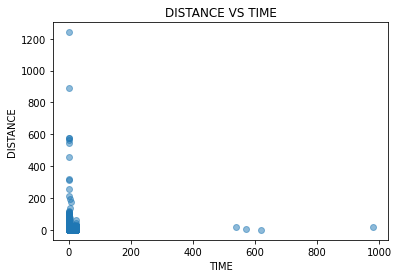

In [ ]:
plt.scatter(nycc['trip_duration'], nycc['distance_in_km'], alpha=0.5)
plt.title('DISTANCE VS TIME')
plt.xlabel('TIME')
plt.ylabel('DISTANCE')
plt.show()

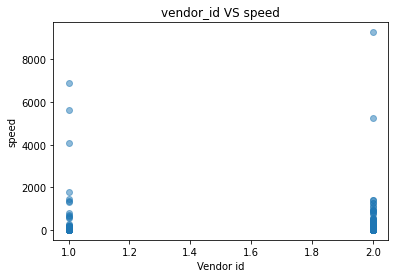

In [ ]:
plt.scatter(nycc['vendor_id'], nycc['Speed_of_trip_in_km/h'], alpha=0.5)
plt.title('vendor_id VS speed')
plt.xlabel('Vendor id')
plt.ylabel('speed')
plt.show()

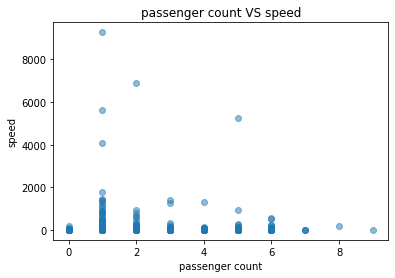

In [ ]:
plt.scatter(nycc['passenger_count'], nycc['Speed_of_trip_in_km/h'], alpha=0.5)
plt.title('passenger count VS speed')
plt.xlabel('passenger count')
plt.ylabel('speed')
plt.show()

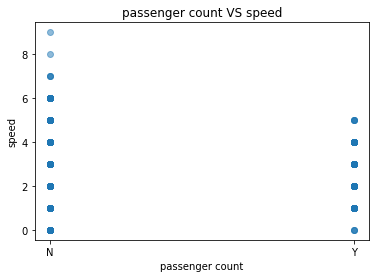

In [ ]:
plt.scatter(nycc['store_and_fwd_flag'],nycc['passenger_count'], alpha=0.5)
plt.title('passenger count VS speed')
plt.xlabel('passenger count')
plt.ylabel('speed')
plt.show()

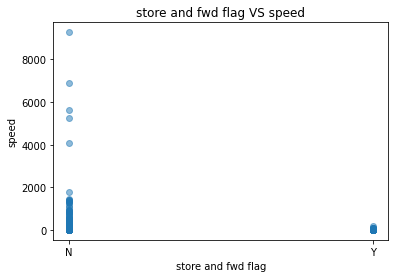

In [ ]:
plt.scatter(nycc['store_and_fwd_flag'],nycc['Speed_of_trip_in_km/h'], alpha=0.5)
plt.title('store and fwd flag VS speed')
plt.xlabel('store and fwd flag')
plt.ylabel('speed')
plt.show()